In [182]:
import numpy as np
from scipy.signal import argrelextrema
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [183]:
df = pd.read_csv ('../data/bitcoin.csv')

df = df.drop('Volume', axis=1)

df_filtrado_4 = df.loc[(df['Date'] >= '2019-11-22') & (df['Date'] <= '2020-01-14')]



In [184]:
def find_filtered_local_extrema(df, column_name):
    """
    Encuentra los índices de los mínimos y máximos locales en una columna de un DataFrame,
    asegurándose de que cada mínimo es menor que todos los valores anteriores y cada máximo es mayor que todos los valores anteriores.
    """

    # Convertir la columna a un array de Numpy
    values = df[column_name].values
    
    # Encontrar índices de mínimos locales
    local_min_indices = argrelextrema(values, np.less)[0]
    
    # Encontrar índices de máximos locales
    local_max_indices = argrelextrema(values, np.greater)[0]
    
    # Filtrando mínimos. Si hay uno minimo y luego un minimo menor.

    filtered_min_indices = [] # Guardamos el indice
    current_min = np.inf  # Guardamos el precio 
    
    for index in local_min_indices:
        if values[index] < current_min:
            filtered_min_indices.append(index)
            current_min = values[index]
    
    # Filtrando máximos
    filtered_max_indices = []
    current_max = -np.inf 
    
    for index in local_max_indices:
        if values[index] > current_max:
            filtered_max_indices.append(index)
            current_max = values[index]
    
    return np.array(filtered_min_indices), np.array(filtered_max_indices)

# Encuentra los mínimos y máximos locales filtrados
filtered_min_indices, filtered_max_indices = find_filtered_local_extrema(df_filtrado_4, 'Adj Close')

# Crear DataFrames para los mínimos y máximos locales filtrados
df_min_filtered = df_filtrado_4.iloc[filtered_min_indices]
df_max_filtered = df_filtrado_4.iloc[filtered_max_indices]

# Mostrar los DataFrames de mínimos y máximos locales filtrados
print("Mínimos locales filtrados:")
print(df_min_filtered)
print("\nMáximos locales filtrados:")
print(df_max_filtered)

Mínimos locales filtrados:
            Date    Adj Close
1894  2019-11-24  7047.916992
1917  2019-12-17  6640.515137

Máximos locales filtrados:
            Date    Adj Close
1893  2019-11-23  7397.796875
1897  2019-11-27  7531.663574
1899  2019-11-29  7761.243652
1938  2020-01-07  8163.692383
1941  2020-01-10  8166.554199
1943  2020-01-12  8192.494141


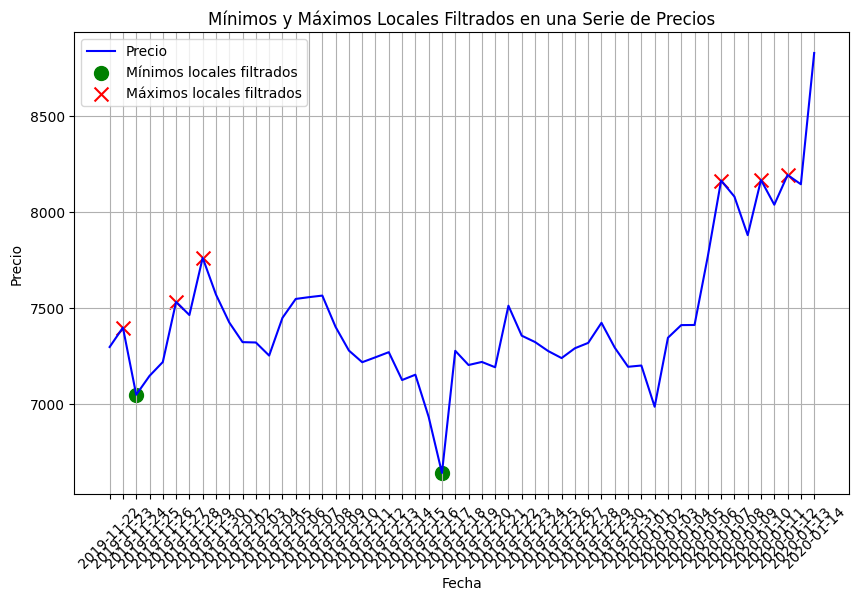

In [185]:

def plot_local_minima_maxima(df, df_min, df_max):

    # Graficar los datos y marcar los mínimos y máximos locales
    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df['Adj Close'], label='Precio', color='blue')
    
    # Marcar los mínimos locales
    plt.scatter(df_min['Date'], df_min['Adj Close'], color='green', label='Mínimos locales filtrados', s=100, marker='o')
    
    # Marcar los máximos locales
    plt.scatter(df_max['Date'], df_max['Adj Close'], color='red', label='Máximos locales filtrados', s=100, marker='x')
    
    # Configurar etiquetas y título del gráfico
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.title('Mínimos y Máximos Locales Filtrados en una Serie de Precios')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Llama a la función plot_local_minima_maxima con tu DataFrame y los DataFrames de mínimos y máximos locales filtrados
plot_local_minima_maxima(df_filtrado_4, df_min_filtered, df_max_filtered)

In [186]:
def resistencias(df, column_name, max_indices, days_after_max=7):
    """
    Cuenta cuántos valores en la columna están por encima de cada valor en los índices máximos locales,
    la cantidad de días por debajo del valor máximo en los siguientes días especificados y el precio en el máximo local.

    Args:
    - df (DataFrame): DataFrame que contiene la serie de precio_resis.
    - column_name (str): El nombre de la columna a analizar.
    - max_indices (np.array): Índices de los máximos locales.
    - days_after_max (int): Número de días después de cada máximo local para considerar.

    Returns:
    - list, list, list: Tres listas, una con el conteo de valores por encima de cada máximo local en los días especificados,
                        otra con la cantidad de días por debajo del valor máximo en los días especificados,
                        y otra con el precio en cada máximo local.
    """
    values = df[column_name].values
    count_above_max = []
    days_below_max = []
    max_prices = []

    for index in max_indices:
        count = np.sum(values[index:index + days_after_max] > values[index])
        count_above_max.append(count)
        days = np.sum(values[index + 1:index + days_after_max] < values[index])
        days_below_max.append(days)
        max_prices.append(values[index])

    return count_above_max, days_below_max, max_prices

# Llamadas a la función para obtener los resultados
counts_above_max_7, days_below_max_7, max_prices_7 = resistencias(df_filtrado_4, 'Adj Close', filtered_max_indices, days_after_max=7)
counts_above_max_15, days_below_max_15, max_prices_15 = resistencias(df_filtrado_4, 'Adj Close', filtered_max_indices, days_after_max=15)
counts_above_max_30, days_below_max_30, max_prices_30 = resistencias(df_filtrado_4, 'Adj Close', filtered_max_indices, days_after_max=30)
counts_above_max_45, days_below_max_45, max_prices_45 = resistencias(df_filtrado_4, 'Adj Close', filtered_max_indices, days_after_max=45)

# Mostrar los resultados
print("Conteo de valores por encima de cada máximo local, la cantidad de días por debajo del valor máximo y el precio en los siguientes 7 días:")
for i, (count, days, price) in enumerate(zip(counts_above_max_7, days_below_max_7, max_prices_7)):
    if days >= 7 * 0.7:
        print(f"Máximo local en índice {filtered_max_indices[i]} ({df_filtrado_4.iloc[filtered_max_indices[i]]['Date']}): Precio: {price}, {count} valores por encima, {days} días por debajo del valor máximo")

print("\nConteo de valores por encima de cada máximo local, la cantidad de días por debajo del valor máximo y el precio en los siguientes 15 días:")
for i, (count, days, price) in enumerate(zip(counts_above_max_15, days_below_max_15, max_prices_15)):
    if days >= 15 * 0.7:
        print(f"Máximo local en índice {filtered_max_indices[i]} ({df_filtrado_4.iloc[filtered_max_indices[i]]['Date']}): Precio: {price}, {count} valores por encima, {days} días por debajo del valor máximo")

print("\nConteo de valores por encima de cada máximo local, la cantidad de días por debajo del valor máximo y el precio en los siguientes 30 días:")
for i, (count, days, price) in enumerate(zip(counts_above_max_30, days_below_max_30, max_prices_30)):
    if days >= 30 * 0.7:
        print(f"Máximo local en índice {filtered_max_indices[i]} ({df_filtrado_4.iloc[filtered_max_indices[i]]['Date']}): Precio: {price}, {count} valores por encima, {days} días por debajo del valor máximo")


print("\nConteo de valores por encima de cada máximo local, la cantidad de días por debajo del valor máximo y el precio en los siguientes 45 días:")

precio_resis = []

for i, (count, days, price) in enumerate(zip(counts_above_max_45, days_below_max_45, max_prices_45)):
    
    

    if days >= 45 * 0.7:
        precio_resis.append (price)
        print(f"Máximo local en índice {filtered_max_indices[i]} ({df_filtrado_4.iloc[filtered_max_indices[i]]['Date']}): Precio: {price}, {count} valores por encima, {days} días por debajo del valor máximo")
        print (precio_resis)


Conteo de valores por encima de cada máximo local, la cantidad de días por debajo del valor máximo y el precio en los siguientes 7 días:
Máximo local en índice 7 (2019-11-29): Precio: 7761.24365234375, 0 valores por encima, 6 días por debajo del valor máximo

Conteo de valores por encima de cada máximo local, la cantidad de días por debajo del valor máximo y el precio en los siguientes 15 días:
Máximo local en índice 7 (2019-11-29): Precio: 7761.24365234375, 0 valores por encima, 14 días por debajo del valor máximo

Conteo de valores por encima de cada máximo local, la cantidad de días por debajo del valor máximo y el precio en los siguientes 30 días:
Máximo local en índice 5 (2019-11-27): Precio: 7531.66357421875, 5 valores por encima, 24 días por debajo del valor máximo
Máximo local en índice 7 (2019-11-29): Precio: 7761.24365234375, 0 valores por encima, 29 días por debajo del valor máximo

Conteo de valores por encima de cada máximo local, la cantidad de días por debajo del valor m

In [187]:
def soportes(df, column_name, min_indices, days_after_min=7):
    """
    Cuenta cuántos valores en la columna están por debajo de cada valor en los índices mínimos locales,
    la cantidad de días por encima del valor mínimo en los siguientes días especificados y el precio en el mínimo local.

    Args:
    - df (DataFrame): DataFrame que contiene la serie de precios.
    - column_name (str): El nombre de la columna a analizar.
    - min_indices (np.array): Índices de los mínimos locales.
    - days_after_min (int): Número de días después de cada mínimo local para considerar.

    Returns:
    - list, list, list: Tres listas, una con el conteo de valores por debajo de cada mínimo local en los días especificados,
                        otra con la cantidad de días por encima del valor mínimo en los días especificados,
                        y otra con el precio en cada mínimo local.
    """
    values = df[column_name].values
    count_below_min = []
    days_above_min = []
    min_prices = []

    for index in min_indices:
        count = np.sum(values[index:index + days_after_min] < values[index])
        count_below_min.append(count)
        days = np.sum(values[index + 1:index + days_after_min] > values[index])
        days_above_min.append(days)
        min_prices.append(values[index])

    return count_below_min, days_above_min, min_prices

# Llamadas a la función para obtener los resultados de soportes
counts_below_min_7, days_above_min_7, min_prices_7 = soportes(df_filtrado_4, 'Adj Close', filtered_min_indices, days_after_min=7)
counts_below_min_15, days_above_min_15, min_prices_15 = soportes(df_filtrado_4, 'Adj Close', filtered_min_indices, days_after_min=15)
counts_below_min_30, days_above_min_30, min_prices_30 = soportes(df_filtrado_4, 'Adj Close', filtered_min_indices, days_after_min=30)
counts_below_min_45, days_above_min_45, min_prices_45 = soportes(df_filtrado_4, 'Adj Close', filtered_min_indices, days_after_min=45)

# Mostrar los resultados de soportes
print("\nConteo de valores por debajo de cada mínimo local, la cantidad de días por encima del valor mínimo y el precio en los siguientes 7 días:")
for i, (count, days, price) in enumerate(zip(counts_below_min_7, days_above_min_7, min_prices_7)):
    if days >= 7 * 0.7:
        print(f"Mínimo local en índice {filtered_min_indices[i]} ({df_filtrado_4.iloc[filtered_min_indices[i]]['Date']}): Precio: {price}, {count} valores por debajo, {days} días por encima del valor mínimo")

print("\nConteo de valores por debajo de cada mínimo local, la cantidad de días por encima del valor mínimo y el precio en los siguientes 15 días:")
for i, (count, days, price) in enumerate(zip(counts_below_min_15, days_above_min_15, min_prices_15)):
    if days >= 15 * 0.7:
        print(f"Mínimo local en índice {filtered_min_indices[i]} ({df_filtrado_4.iloc[filtered_min_indices[i]]['Date']}): Precio: {price}, {count} valores por debajo, {days} días por encima del valor mínimo")

print("\nConteo de valores por debajo de cada mínimo local, la cantidad de días por encima del valor mínimo y el precio en los siguientes 30 días:")
for i, (count, days, price) in enumerate(zip(counts_below_min_30, days_above_min_30, min_prices_30)):
    if days >= 30 * 0.7:
        print(f"Mínimo local en índice {filtered_min_indices[i]} ({df_filtrado_4.iloc[filtered_min_indices[i]]['Date']}): Precio: {price}, {count} valores por debajo, {days} días por encima del valor mínimo")

print("\nConteo de valores por debajo de cada mínimo local, la cantidad de días por encima del valor mínimo y el precio en los siguientes 45 días:")
for i, (count, days, price) in enumerate(zip(counts_below_min_45, days_above_min_45, min_prices_45)):
    if days >= 45 * 0.7:
        print(f"Mínimo local en índice {filtered_min_indices[i]} ({df_filtrado_4.iloc[filtered_min_indices[i]]['Date']}): Precio: {price}, {count} valores por debajo, {days} días por encima del valor mínimo")



Conteo de valores por debajo de cada mínimo local, la cantidad de días por encima del valor mínimo y el precio en los siguientes 7 días:
Mínimo local en índice 2 (2019-11-24): Precio: 7047.9169921875, 0 valores por debajo, 6 días por encima del valor mínimo
Mínimo local en índice 25 (2019-12-17): Precio: 6640.51513671875, 0 valores por debajo, 6 días por encima del valor mínimo

Conteo de valores por debajo de cada mínimo local, la cantidad de días por encima del valor mínimo y el precio en los siguientes 15 días:
Mínimo local en índice 2 (2019-11-24): Precio: 7047.9169921875, 0 valores por debajo, 14 días por encima del valor mínimo
Mínimo local en índice 25 (2019-12-17): Precio: 6640.51513671875, 0 valores por debajo, 14 días por encima del valor mínimo

Conteo de valores por debajo de cada mínimo local, la cantidad de días por encima del valor mínimo y el precio en los siguientes 30 días:
Mínimo local en índice 2 (2019-11-24): Precio: 7047.9169921875, 2 valores por debajo, 27 días 

In [188]:
min_prices_45

[7047.9169921875, 6640.51513671875]

In [189]:
max_prices_45

[7397.796875,
 7531.66357421875,
 7761.24365234375,
 8163.6923828125,
 8166.55419921875,
 8192.494140625]

In [190]:
precio_resis

[7531.66357421875, 7761.24365234375]

In [191]:
import pandas as pd



soporte = 7047.916992
resistencias = precio_resis

# Crear los rangos
rangos = [(soporte, res) for res in resistencias]

# Inicializar una lista para almacenar los resultados
range_counts = []

# Calcular cuántos días el precio está dentro de cada rango
for min_price, max_price in rangos:
    count = df_filtrado_4[(df_filtrado_4['Adj Close'] >= min_price) & (df_filtrado_4['Adj Close'] <= max_price)].shape[0]
    range_counts.append(count)

# Crear un DataFrame con los rangos y los conteos
df_ranges = pd.DataFrame(rangos, columns=['Min Price', 'Max Price'])
df_ranges['Days in Range'] = range_counts

print("Rangos con conteo de días:")
print(df_ranges)

 

Rangos con conteo de días:
     Min Price    Max Price  Days in Range
0  7047.916992  7531.663574             37
1  7047.916992  7761.243652             42


In [192]:
import pandas as pd

# Asegúrate de que min_prices_45 y precio_resis son listas de precios
soportes = min_prices_45  # Cambia min_prices_45 por la lista real de precios de soporte
resistencias = precio_resis  # Cambia precio_resis por la lista real de precios de resistencia

# Crear los rangos combinando cada valor de soporte con cada valor de resistencia
rangos = [(sop, res) for sop in soportes for res in resistencias]

# Inicializar una lista para almacenar los resultados
range_counts = []

# Calcular cuántos días el precio está dentro de cada rango
for min_price, max_price in rangos:
    count = df_filtrado_4[(df_filtrado_4['Adj Close'] >= min_price) & (df_filtrado_4['Adj Close'] <= max_price)].shape[0]
    range_counts.append(count)

# Crear un DataFrame con los rangos y los conteos
df_ranges = pd.DataFrame(rangos, columns=['Min Price', 'Max Price'])
df_ranges['Days in Range'] = range_counts

# Añadir la diferencia de precio entre los rangos
df_ranges['Price Difference'] = df_ranges['Max Price'] - df_ranges['Min Price']

print("Rangos con conteo de días y diferencia de precio:")
print(df_ranges)


Rangos con conteo de días y diferencia de precio:
     Min Price    Max Price  Days in Range  Price Difference
0  7047.916992  7531.663574             37        483.746582
1  7047.916992  7761.243652             42        713.326660
2  6640.515137  7531.663574             40        891.148438
3  6640.515137  7761.243652             45       1120.728516


In [193]:
import pandas as pd

# Asegúrate de que min_prices_45 y precio_resis son listas de precios
soportes = min_prices_45  # Cambia min_prices_45 por la lista real de precios de soporte
resistencias = precio_resis  # Cambia precio_resis por la lista real de precios de resistencia

# Crear los rangos combinando cada valor de soporte con cada valor de resistencia
rangos = [(sop, res) for sop in soportes for res in resistencias]

# Inicializar listas para almacenar los resultados
range_counts = []
percentage_ranges = []

# Calcular cuántos días el precio está dentro de cada rango y el rango en porcentaje
for min_price, max_price in rangos:
    prices_in_range = df_filtrado_4[(df_filtrado_4['Adj Close'] >= min_price) & (df_filtrado_4['Adj Close'] <= max_price)]['Adj Close']
    count = prices_in_range.shape[0]
    percentage_range = ((max_price - min_price) / min_price) * 100 if min_price != 0 else 0
    range_counts.append(count)
    percentage_ranges.append(percentage_range)

# Crear un DataFrame con los rangos, los conteos y el rango en porcentaje
df_ranges = pd.DataFrame(rangos, columns=['Min Price', 'Max Price'])
df_ranges['Days in Range'] = range_counts
df_ranges['Percentage Range'] = percentage_ranges

print("Rangos con conteo de días y rango en porcentaje:")
print(df_ranges)


Rangos con conteo de días y rango en porcentaje:
     Min Price    Max Price  Days in Range  Percentage Range
0  7047.916992  7531.663574             37          6.863682
1  7047.916992  7761.243652             42         10.121099
2  6640.515137  7531.663574             40         13.419869
3  6640.515137  7761.243652             45         16.877132


In [196]:
import pandas as pd

# Supongamos que df_ranges y df_filtrado_4 ya están definidos
# df_ranges tiene las columnas: Min Price, Max Price, Percentage Range
# df_filtrado_4 tiene la columna: Adj Close

# Paso 1: Calcular el 10% de la columna "Percentage Range"
df_ranges['Percentage 10%'] = df_ranges['Percentage Range'] * 0.1

# Paso 2: Calcular los nuevos rangos basados en el 10% de "Percentage Range"
df_ranges['Min Range UP'] = df_ranges['Min Price'] * (1 + df_ranges['Percentage 10%'] / 100)
df_ranges['Min Range DOWN'] = df_ranges['Min Price'] * (1 - df_ranges['Percentage 10%'] / 100)

df_ranges['Max Range UP'] = df_ranges['Max Price'] * (1 - df_ranges['Percentage 10%'] / 100)
df_ranges['Max Range DOWN'] = df_ranges['Max Price'] * (1 + df_ranges['Percentage 10%'] / 100)



soporteko = df_ranges [['Min Range UP', 'Min Range DOWN']]

soporteko

,Min Range UP,Min Range DOWN
0,7096.291650,6999.542334
1,7119.249658,6976.584326
2,6729.629980,6551.400293
3,6752.587988,6528.442285


In [197]:
df_ranges

,Min Price,Max Price,Days in Range,Percentage Range,Percentage 10%,Min Range UP,Min Range DOWN,Max Range UP,Max Range DOWN
0,7047.916992,7531.663574,37,6.863682,0.686368,7096.291650,6999.542334,7479.968633,7583.358515
1,7047.916992,7761.243652,42,10.121099,1.012110,7119.249658,6976.584326,7682.691337,7839.795968
2,6640.515137,7531.663574,40,13.419869,1.341987,6729.629980,6551.400293,7430.589635,7632.737513
3,6640.515137,7761.243652,45,16.877132,1.687713,6752.587988,6528.442285,7630.256118,7892.231187


In [198]:
def count_prices_in_range(df_filtrado_4, lower_bound, upper_bound):
    
    return ((df_filtrado_4['Adj Close'] >= lower_bound) & (df_filtrado_4['Adj Close'] <= upper_bound)).sum()

# Aplicar la función a cada fila dedf_ranges
df_ranges['Count in Range'] =df_ranges.apply(lambda row: count_prices_in_range(df_filtrado_4, row['Min Range DOWN'], row['Min Range UP']), axis=1)

print(df_ranges)



     Min Price    Max Price  Days in Range  Percentage Range  Percentage 10%  \
0  7047.916992  7531.663574             37          6.863682        0.686368   
1  7047.916992  7761.243652             42         10.121099        1.012110   
2  6640.515137  7531.663574             40         13.419869        1.341987   
3  6640.515137  7761.243652             45         16.877132        1.687713   

   Min Range UP  Min Range DOWN  Max Range UP  Max Range DOWN  Count in Range  
0   7096.291650     6999.542334   7479.968633     7583.358515               1  
1   7119.249658     6976.584326   7682.691337     7839.795968               2  
2   6729.629980     6551.400293   7430.589635     7632.737513               1  
3   6752.587988     6528.442285   7630.256118     7892.231187               1  


In [212]:
df_soporte = df_ranges [['Min Price', 'Min Range UP', 'Min Range DOWN']]

df_soporte

,Min Price,Min Range UP,Min Range DOWN
0,7047.916992,7096.291650,6999.542334
1,7047.916992,7119.249658,6976.584326
2,6640.515137,6729.629980,6551.400293
3,6640.515137,6752.587988,6528.442285


In [231]:
def precios_en_rango_res(df, alto, bajo):
    # Filtra los datos que están en el rango [bajo, alto]
    dias_cerca_resistencia = df[(df['Adj Close'] >= bajo) & (df['Adj Close'] <= alto)]
    # Imprime los valores para verificar el filtrado
    #print("Valores en rango:")
    #print(dias_cerca_resistencia)
    # Calcula el total de días en el rango
    total_dias = len(dias_cerca_resistencia)
    return total_dias

# Ejemplo de uso
total_dias_cerca_resistencia = precios_en_rango_res(df_filtrado_4, 7096, 6990)
print("El total de días cerca de la resistencia es:", total_dias_cerca_resistencia )

El total de días cerca de la resistencia es: 1


In [226]:
for index, row in df_soporte.iterrows():
    resis = row ['Min Price']
    alto = row['Min Range UP']
    bajo = row['Min Range DOWN']
    total_dias_cerca_resistencia = precios_en_rango_res(df_filtrado_4, alto, bajo)
    print(f"El total de días cerca de la resistencia {resis} con alto {alto} y bajo {bajo} es: {total_dias_cerca_resistencia}")


El total de días cerca de la resistencia 7047.9169921875 con alto 7096.291650390624 y bajo 6999.542333984376 es: 1
El total de días cerca de la resistencia 7047.9169921875 con alto 7119.249658203124 y bajo 6976.584326171875 es: 2
El total de días cerca de la resistencia 6640.51513671875 con alto 6729.629980468751 y bajo 6551.400292968749 es: 1
El total de días cerca de la resistencia 6640.51513671875 con alto 6752.58798828125 y bajo 6528.44228515625 es: 1
